In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
data = pd.read_csv("myo_raw_glove2.csv")

In [3]:
data.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Thumb,Index,Middle,Ring,Pinky
0,22,30,116,106,50,47,38,24,511,511,511,511,511
1,21,39,110,150,53,44,36,26,511,511,511,511,511
2,28,49,139,151,56,44,35,28,511,511,511,511,511
3,31,51,146,154,65,48,33,30,511,511,511,511,511
4,45,60,181,142,76,59,33,29,511,511,511,511,511


In [4]:
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
myo_cols = ["Channel_1", "Channel_2", "Channel_3", "Channel_4", "Channel_5", "Channel_6", "Channel_7", "Channel_8"]

In [5]:
df = data.copy(deep=True)

<AxesSubplot:>

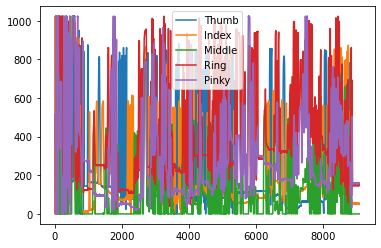

In [6]:
df[finger_names].plot()

<AxesSubplot:>

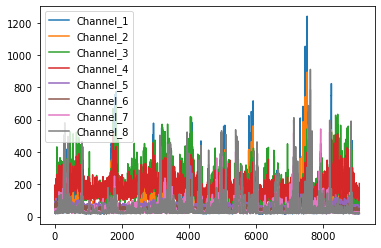

In [7]:
df[myo_cols].plot()

In [8]:
print("Correlation Matrix")
print()

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

Correlation Matrix

Top Absolute Correlations
Channel_7  Channel_8    0.955025
Channel_1  Channel_2    0.923527
Channel_5  Channel_6    0.711206
Channel_3  Channel_4    0.694407
Index      Middle       0.599518
Ring       Pinky        0.590854
Channel_6  Channel_7    0.581009
Channel_1  Pinky        0.580883
Channel_2  Channel_3    0.556354
           Pinky        0.547149
dtype: float64


# Making a full hand baseline

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8']

X = df[x_cols]
y = df.drop(x_cols,1)

train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

# Making our benchmark model
# Just predict the mean average number of bikes. 
y_train_mean = train_y.mean()

train_preds = np.ones(train_y.shape) * y_train_mean
preds = np.ones(test_y.shape) * y_train_mean

rmse = np.sqrt(mean_squared_error(train_y, train_preds))
print("Train RMSE: %f" % (rmse))

mae = mean_absolute_error(train_y, train_preds)
print("Train MAE: %f" % (mae))

rmse = np.sqrt(mean_squared_error(test_y, preds))
print("Test RMSE: %f" % (rmse))

mae = mean_absolute_error(test_y, preds)
print("Test MAE: %f" % (mae))

r2_score(test_y, preds)

Train RMSE: 256.778896
Train MAE: 201.907554
Test RMSE: 258.439046
Test MAE: 202.897870


-0.13914694451892826

In [10]:
X

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8
0,22,30,116,106,50,47,38,24
1,21,39,110,150,53,44,36,26
2,28,49,139,151,56,44,35,28
3,31,51,146,154,65,48,33,30
4,45,60,181,142,76,59,33,29
...,...,...,...,...,...,...,...,...
9091,23,22,81,145,62,50,25,23
9092,21,22,95,158,58,45,25,21
9093,20,26,99,163,57,43,23,19
9094,20,25,99,195,54,38,21,20


In [11]:
y

,Thumb,Index,Middle,Ring,Pinky
0,511,511,511,511,511
1,511,511,511,511,511
2,511,511,511,511,511
3,511,511,511,511,511
4,511,511,511,511,511
...,...,...,...,...,...
9091,54,55,0,150,160
9092,52,53,0,147,160
9093,52,53,0,147,160
9094,50,53,0,147,160


# Making a baseline Neural Network

In [12]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [13]:
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8']

X = abs(df[x_cols])
y = df.drop(x_cols,1)

rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)
# Fit the scaler on the training set.
train_X = emg_scaler.fit_transform(train_X)
train_y = rel_hand_scaler.fit_transform(train_y)
# Scale the output data.
test_X = emg_scaler.transform(test_X)
test_y = rel_hand_scaler.transform(test_y)

In [14]:
model = Sequential()

# The Input Layer :
model.add(Dense(16,input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))

# The Output Layer :
model.add(Dense(5,activation='linear'))

# Compile the network :
model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 3,125
Trainable params: 3,125
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(test_X, test_y))

Epoch 1/200
214/214 [==============================] - 12s 4ms/step - loss: 0.9006 - val_loss: 0.7264
Epoch 2/200
214/214 [==============================] - 1s 3ms/step - loss: 0.7220 - val_loss: 0.6881
Epoch 3/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6786 - val_loss: 0.6690
Epoch 4/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6819 - val_loss: 0.6537
Epoch 5/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6619 - val_loss: 0.6410
Epoch 6/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6609 - val_loss: 0.6269
Epoch 7/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6282 - val_loss: 0.6319
Epoch 8/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6102 - val_loss: 0.6134
Epoch 9/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6218 - val_loss: 0.6107
Epoch 10/200
214/214 [==============================] - 1s 3ms/step - loss: 0.6136 - val_l

214/214 [==============================] - 1s 3ms/step - loss: 0.4839 - val_loss: 0.5456
Epoch 82/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4844 - val_loss: 0.5424
Epoch 83/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4862 - val_loss: 0.5376
Epoch 84/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4769 - val_loss: 0.5420
Epoch 85/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4809 - val_loss: 0.5422
Epoch 86/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4827 - val_loss: 0.5416
Epoch 87/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4619 - val_loss: 0.5454
Epoch 88/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4679 - val_loss: 0.5360
Epoch 89/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4812 - val_loss: 0.5429
Epoch 90/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4635 - val_loss: 

Epoch 161/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4295 - val_loss: 0.5573
Epoch 162/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4491 - val_loss: 0.5447
Epoch 163/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4296 - val_loss: 0.5473
Epoch 164/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4456 - val_loss: 0.5496
Epoch 165/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4343 - val_loss: 0.5445
Epoch 166/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4310 - val_loss: 0.5546
Epoch 167/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4447 - val_loss: 0.5488
Epoch 168/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4389 - val_loss: 0.5462
Epoch 169/200
214/214 [==============================] - 1s 3ms/step - loss: 0.4475 - val_loss: 0.5489
Epoch 170/200
214/214 [==============================] - 1s 3ms/step - lo

In [39]:
# Evaluate the model on the test data
mse = model.evaluate(test_X, test_y)
mse

16/16 [==============================] - 0s 2ms/step - loss: 2.1049


2.104870557785034

Note that using wrist as the rel_point gives 0.10, which was a lower loss than using the palm

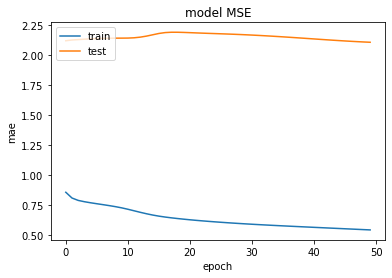

In [40]:
# summarize history for loss
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
prediction = model.predict(train_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-0.12666798  0.36529917  0.30066988  0.3933399   0.99735945]
 [ 0.04665141  0.45973164  0.38556072  0.12310009  0.73268706]
 [ 0.61708313  1.061829    1.0679934   0.29254198  0.8756975 ]
 ...
 [ 0.18489195 -0.41188043 -0.39256337 -0.4393336  -0.30575585]
 [ 0.38115698 -0.46063298 -0.45643264 -0.4635564  -0.30168658]
 [ 0.652985   -0.5346022  -0.50635153 -0.44667265 -0.2566461 ]]
MSE:  28399.965
RMSE:  168.52289
MAE:  120.06102


In [42]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[-0.22895105 -0.20324829 -0.03273439 -0.15606675 -0.24154128]
 [ 0.03014709 -0.23796198 -0.21201    -0.29726112 -0.34729213]
 [ 0.00222763 -0.2701142  -0.25647977 -0.34576583 -0.4379733 ]
 ...
 [ 0.85107106  1.3735389   1.2479516   0.5058568   0.9701962 ]
 [ 0.4345098   0.9715535   0.88147205  0.47118562  0.9336091 ]
 [ 0.06698394  0.5321983   0.51722044  0.41111234  1.128193  ]]
MSE:  118667.69
RMSE:  344.48178
MAE:  253.15454


# Plot the predicted vs ground truth

### Save the model and the scalers

In [43]:
import joblib

model_name = "NNRel-StanScaled"

model.save(f"../models/{model_name}.h5")
# Save hand scaler to file.
# Scales the output of the network, the relative position of the hand, min_max
joblib.dump(rel_hand_scaler, f'../models/{model_name}-Hand.gz')

# Scales the input to the network, the emg data. 
joblib.dump(emg_scaler, f'../models/{model_name}-EMG.gz')

['../models/NNRel-StanScaled-EMG.gz']

In [44]:
# Making a prediction in the prediction script.
from keras.models import load_model
model = load_model(f"../models/{model_name}.h5")

input_scaler = joblib.load(f'../models/{model_name}-EMG.gz')
output_scaler = joblib.load(f'../models/{model_name}-Hand.gz')

# Get some input data
semg_input = np.array([[ 31, 140, 140,  83,  42,  30,  22,  21]])
# Scale the input
scaled_input = input_scaler.transform(semg_input)
# Get a prediction
pred = model.predict(scaled_input)
# Scale it back to a value
scaled_pred = output_scaler.inverse_transform(pred)
scaled_pred

ValueError: X has 8 features, but this StandardScaler is expecting 16 features as input.

In [ ]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

# LSTMs

In [45]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import LSTM

In [46]:
y_cols = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df[y_cols]
X = df[x_cols]

In [47]:
def gen_seqs(X, timesteps=2):
    sX = X.astype('float32')
    for col_name in X:
        for t in range(1,timesteps):
            # Add the past col name
            sX[col_name+"_p"+str(t)] = X[col_name].shift(t)
    # Drop NaNs
    sX.dropna(inplace=True)
    return sX

Xs = gen_seqs(X)

In [48]:
Xs.shape

(9095, 16)

In [49]:
rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(Xs)

# Ensure all data is a 32bit
nX = nX.astype('float32')
ny = ny.astype('float32')

# Reshape Scaled X
features = X.shape[1]
observations = Xs.shape[0]
timesteps = 2

nX = nX.reshape(observations, features, timesteps)

# Delete the labels, we no longer have data for
ny = ny[timesteps-1:]

In [50]:
ny.shape, nX.shape

((9095, 5), (9095, 8, 2))

In [51]:
ny

array([[ 1.3941878 ,  1.4262358 ,  1.5600916 ,  0.29161566,  0.8830306 ],
       [ 1.3941878 ,  1.4262358 ,  1.5600916 ,  0.29161566,  0.8830306 ],
       [ 1.3941878 ,  1.4262358 ,  1.5600916 ,  0.29161566,  0.8830306 ],
       ...,
       [-0.68988633, -0.6594196 , -0.6733267 , -1.0351189 , -0.581931  ],
       [-0.6989673 , -0.6594196 , -0.6733267 , -1.0351189 , -0.581931  ],
       [-0.68988633, -0.6594196 , -0.6733267 , -1.0241842 , -0.581931  ]],
      dtype=float32)

In [52]:
rel_hand_scaler.transform(y)

array([[ 1.39418775,  1.42623577,  1.56009163,  0.29161565,  0.88303056],
       [ 1.39418775,  1.42623577,  1.56009163,  0.29161565,  0.88303056],
       [ 1.39418775,  1.42623577,  1.56009163,  0.29161565,  0.88303056],
       ...,
       [-0.68988634, -0.6594196 , -0.67332666, -1.03511888, -0.58193097],
       [-0.69896727, -0.6594196 , -0.67332666, -1.03511888, -0.58193097],
       [-0.68988634, -0.6594196 , -0.67332666, -1.02418426, -0.58193097]])

In [53]:
y.head()

,Thumb,Index,Middle,Ring,Pinky
0,511,511,511,511,511
1,511,511,511,511,511
2,511,511,511,511,511
3,511,511,511,511,511
4,511,511,511,511,511


In [54]:
Xs

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Channel_1_p1,Channel_2_p1,Channel_3_p1,Channel_4_p1,Channel_5_p1,Channel_6_p1,Channel_7_p1,Channel_8_p1
1,21.0,39.0,110.0,150.0,53.0,44.0,36.0,26.0,22.0,30.0,116.0,106.0,50.0,47.0,38.0,24.0
2,28.0,49.0,139.0,151.0,56.0,44.0,35.0,28.0,21.0,39.0,110.0,150.0,53.0,44.0,36.0,26.0
3,31.0,51.0,146.0,154.0,65.0,48.0,33.0,30.0,28.0,49.0,139.0,151.0,56.0,44.0,35.0,28.0
4,45.0,60.0,181.0,142.0,76.0,59.0,33.0,29.0,31.0,51.0,146.0,154.0,65.0,48.0,33.0,30.0
5,45.0,59.0,178.0,128.0,83.0,60.0,34.0,25.0,45.0,60.0,181.0,142.0,76.0,59.0,33.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9091,23.0,22.0,81.0,145.0,62.0,50.0,25.0,23.0,20.0,22.0,68.0,125.0,61.0,47.0,23.0,21.0
9092,21.0,22.0,95.0,158.0,58.0,45.0,25.0,21.0,23.0,22.0,81.0,145.0,62.0,50.0,25.0,23.0
9093,20.0,26.0,99.0,163.0,57.0,43.0,23.0,19.0,21.0,22.0,95.0,158.0,58.0,45.0,25.0,21.0
9094,20.0,25.0,99.0,195.0,54.0,38.0,21.0,20.0,20.0,26.0,99.0,163.0,57.0,43.0,23.0,19.0


In [55]:
df.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Thumb,Index,Middle,Ring,Pinky
0,22,30,116,106,50,47,38,24,511,511,511,511,511
1,21,39,110,150,53,44,36,26,511,511,511,511,511
2,28,49,139,151,56,44,35,28,511,511,511,511,511
3,31,51,146,154,65,48,33,30,511,511,511,511,511
4,45,60,181,142,76,59,33,29,511,511,511,511,511


In [56]:
train_X = nX[500:,:]
test_X = nX[:500,:]

train_y = ny[500:,:] # Train on the last 11466
test_y = ny[:500,:] # Test on the last 500

In [57]:
train_X.shape, train_y.shape

((8595, 8, 2), (8595, 5))

## Simple RNN Arc

In [58]:
model = Sequential()
# 8 Features and 2 timesteps
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(5))

model.compile(loss='mse', optimizer='adam')

In [59]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
120/120 - 2s - loss: 0.8583 - val_loss: 2.1103
Epoch 2/50
120/120 - 0s - loss: 0.8055 - val_loss: 2.1264
Epoch 3/50
120/120 - 0s - loss: 0.7842 - val_loss: 2.1332
Epoch 4/50
120/120 - 0s - loss: 0.7732 - val_loss: 2.1368
Epoch 5/50
120/120 - 0s - loss: 0.7646 - val_loss: 2.1384
Epoch 6/50
120/120 - 0s - loss: 0.7569 - val_loss: 2.1388
Epoch 7/50
120/120 - 0s - loss: 0.7494 - val_loss: 2.1385
Epoch 8/50
120/120 - 0s - loss: 0.7414 - val_loss: 2.1373
Epoch 9/50
120/120 - 0s - loss: 0.7326 - val_loss: 2.1352
Epoch 10/50
120/120 - 0s - loss: 0.7225 - val_loss: 2.1341
Epoch 11/50
120/120 - 0s - loss: 0.7114 - val_loss: 2.1321
Epoch 12/50
120/120 - 0s - loss: 0.6999 - val_loss: 2.1348
Epoch 13/50
120/120 - 0s - loss: 0.6882 - val_loss: 2.1425
Epoch 14/50
120/120 - 0s - loss: 0.6771 - val_loss: 2.1480
Epoch 15/50
120/120 - 0s - loss: 0.6673 - val_loss: 2.1663
Epoch 16/50
120/120 - 0s - loss: 0.6583 - val_loss: 2.1783
Epoch 17/50
120/120 - 0s - loss: 0.6505 - val_loss: 2.1894
Epoch 

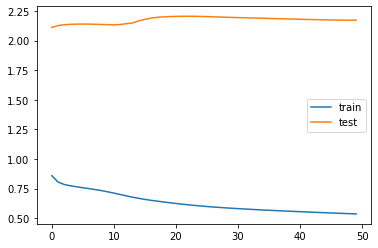

In [60]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [61]:
mse = model.evaluate(test_X, test_y)
mse

16/16 [==============================] - 0s 2ms/step - loss: 2.1714


2.171365261077881

## Longer Timesequence RNN

In [62]:
data = pd.read_csv("myo_raw_glove2.csv")

y_cols = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']


# Get rid of the [1,2,3,4,5]s from then the labeller was breaking
df = df.iloc[90:]

# Rectify by taking the absolute value
df[x_cols] = abs(df[x_cols])

X = df[x_cols]
y = df[y_cols]

# Scaling
rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(X)

timesteps = 20

def gen_seqs(X, timesteps=2):
    sX = X.astype('float32')
    for col_name in X:
        for t in range(1,timesteps):
            # Add the past col name
            sX[col_name+"_p"+str(t)] = X[col_name].shift(t)
    # Drop NaNs
    sX.dropna(inplace=True)
    return sX

Xs = gen_seqs(X, timesteps)

rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(Xs)

# Ensure all data is a 32bit
nX = nX.astype('float32')
ny = ny.astype('float32')

# Reshape Scaled X
features = X.shape[1]
observations = Xs.shape[0]

nX = nX.reshape(observations, features, timesteps)

# Delete the labels, we no longer have data for
ny = ny[timesteps-1:]

train_X = nX[500:,:]
test_X = nX[:500,:]

train_y = ny[500:,:] # Train on the last 11466
test_y = ny[:500,:] # Test on the last 500

In [63]:
model = Sequential()
# 8 Features and 20 timesteps
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(14))
model.add(Dense(5))

model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 8, 64)             21760     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 14)                462       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

In [64]:
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), shuffle=True)

Epoch 1/500
118/118 [==============================] - 4s 11ms/step - loss: 0.7216 - val_loss: 2.6076
Epoch 2/500
118/118 [==============================] - 1s 6ms/step - loss: 0.5139 - val_loss: 2.4983
Epoch 3/500
118/118 [==============================] - 1s 6ms/step - loss: 0.4466 - val_loss: 2.0747
Epoch 4/500
118/118 [==============================] - 1s 6ms/step - loss: 0.4086 - val_loss: 2.1369
Epoch 5/500
118/118 [==============================] - 1s 6ms/step - loss: 0.3847 - val_loss: 1.9866
Epoch 6/500
118/118 [==============================] - 1s 6ms/step - loss: 0.3684 - val_loss: 2.0680
Epoch 7/500
118/118 [==============================] - 1s 6ms/step - loss: 0.3601 - val_loss: 2.0312
Epoch 8/500
118/118 [==============================] - 1s 6ms/step - loss: 0.3459 - val_loss: 2.0063
Epoch 9/500
118/118 [==============================] - 1s 6ms/step - loss: 0.3267 - val_loss: 1.8493
Epoch 10/500
118/118 [==============================] - 1s 6ms/step - loss: 0.3389 - val_l

118/118 [==============================] - 1s 6ms/step - loss: 0.1070 - val_loss: 1.7410
Epoch 82/500
118/118 [==============================] - 1s 6ms/step - loss: 0.1065 - val_loss: 1.7795
Epoch 83/500
118/118 [==============================] - 1s 6ms/step - loss: 0.1041 - val_loss: 1.8217
Epoch 84/500
118/118 [==============================] - 1s 6ms/step - loss: 0.1101 - val_loss: 1.8005
Epoch 85/500
118/118 [==============================] - 1s 6ms/step - loss: 0.1050 - val_loss: 1.7784
Epoch 86/500
118/118 [==============================] - 1s 6ms/step - loss: 0.1126 - val_loss: 1.8761
Epoch 87/500
118/118 [==============================] - 1s 6ms/step - loss: 0.1046 - val_loss: 1.7499
Epoch 88/500
118/118 [==============================] - 1s 6ms/step - loss: 0.1064 - val_loss: 1.7343
Epoch 89/500
118/118 [==============================] - 1s 6ms/step - loss: 0.1075 - val_loss: 1.8217
Epoch 90/500
118/118 [==============================] - 1s 6ms/step - loss: 0.1052 - val_loss: 

Epoch 161/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0829 - val_loss: 1.7694
Epoch 162/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0781 - val_loss: 1.7982
Epoch 163/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0785 - val_loss: 1.8131
Epoch 164/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0772 - val_loss: 1.7995
Epoch 165/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0793 - val_loss: 1.7407
Epoch 166/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0781 - val_loss: 1.7459
Epoch 167/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0799 - val_loss: 1.7412
Epoch 168/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0784 - val_loss: 1.7492
Epoch 169/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0800 - val_loss: 1.7054
Epoch 170/500
118/118 [==============================] - 1s 6ms/step - lo

118/118 [==============================] - 1s 6ms/step - loss: 0.0704 - val_loss: 1.7414
Epoch 241/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0687 - val_loss: 1.7237
Epoch 242/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0698 - val_loss: 1.7512
Epoch 243/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0693 - val_loss: 1.7031
Epoch 244/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0700 - val_loss: 1.7327
Epoch 245/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0692 - val_loss: 1.7599
Epoch 246/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0696 - val_loss: 1.7581
Epoch 247/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0684 - val_loss: 1.7590
Epoch 248/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0711 - val_loss: 1.7198
Epoch 249/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0723 - v

118/118 [==============================] - 1s 6ms/step - loss: 0.0664 - val_loss: 1.8112
Epoch 320/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0666 - val_loss: 1.7371
Epoch 321/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0693 - val_loss: 1.7787
Epoch 322/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0659 - val_loss: 1.7010
Epoch 323/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0650 - val_loss: 1.7569
Epoch 324/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0649 - val_loss: 1.7665
Epoch 325/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0691 - val_loss: 1.6970
Epoch 326/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0672 - val_loss: 1.7256
Epoch 327/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0662 - val_loss: 1.7853
Epoch 328/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0637 - v

118/118 [==============================] - 1s 6ms/step - loss: 0.0643 - val_loss: 1.7433
Epoch 399/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0677 - val_loss: 1.7692
Epoch 400/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0656 - val_loss: 1.6855
Epoch 401/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0648 - val_loss: 1.6829
Epoch 402/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0634 - val_loss: 1.7066
Epoch 403/500
118/118 [==============================] - ETA: 0s - loss: 0.066 - 1s 6ms/step - loss: 0.0667 - val_loss: 1.7663
Epoch 404/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0656 - val_loss: 1.7595
Epoch 405/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0646 - val_loss: 1.7409
Epoch 406/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0629 - val_loss: 1.6881
Epoch 407/500
118/118 [==============================] - 1s 6ms

118/118 [==============================] - 1s 6ms/step - loss: 0.0639 - val_loss: 1.7363
Epoch 478/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0626 - val_loss: 1.7303
Epoch 479/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0641 - val_loss: 1.7010
Epoch 480/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0618 - val_loss: 1.6984
Epoch 481/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0653 - val_loss: 1.6849
Epoch 482/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0627 - val_loss: 1.7670
Epoch 483/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0631 - val_loss: 1.7279
Epoch 484/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0616 - val_loss: 1.7633
Epoch 485/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0606 - val_loss: 1.6987
Epoch 486/500
118/118 [==============================] - 1s 6ms/step - loss: 0.0643 - v

16/16 [==============================] - 0s 3ms/step - loss: 1.7357


1.7356511354446411

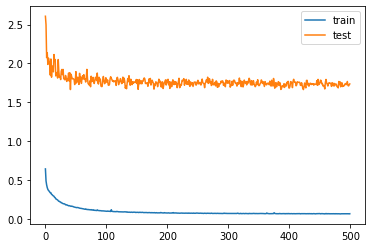

In [65]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

mse = model.evaluate(test_X, test_y)
mse


In [66]:
def get_metrics(model, y_scaler, scaled_X, scaled_y):# Training Metrics
    prediction = model.predict(scaled_X) # scaled inputs here

    # Scaling back the prediction
    preds = y_scaler.inverse_transform(prediction)
    # Scaling back the goals
    goal = y_scaler.inverse_transform(scaled_y)

    MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
    print("MSE: ", MSE)
    print("RMSE: ", np.sqrt(MSE))  # 3rd step
    MAE = mean_absolute_error(goal, preds)
    print("MAE: ", MAE)

In [67]:
print("Train:")
get_metrics(model, rel_hand_scaler, train_X, train_y)
print("\nTest:")
get_metrics(model, rel_hand_scaler, test_X, test_y)

Train:
MSE:  638.20325
RMSE:  25.262686
MAE:  19.013561

Test:
MSE:  96425.56
RMSE:  310.52466
MAE:  215.8865


## Plot of predicted vs truth

In [68]:
# Training Set
train_preds = model.predict(train_X) # scaled inputs here

# Scaling back the prediction
train_preds = rel_hand_scaler.inverse_transform(train_preds)
# Scaling back the goals
train_goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(train_goal, train_preds)  # first 2 steps, combined
print("Train MSE: ", MSE)
print("Train RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(train_goal, train_preds)
print("Train MAE: ", MAE)

print()
# Test Set
test_preds = model.predict(test_X) # scaled inputs here

# Scaling back the prediction
test_preds = rel_hand_scaler.inverse_transform(test_preds)
# Scaling back the goals
test_goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(test_goal, test_preds)  # first 2 steps, combined
print("Test MSE: ", MSE)
print("Test RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(test_goal, test_preds)
print("Test MAE: ", MAE)

train_preds_df = pd.DataFrame(train_preds, columns=y_cols)
train_goals_df = pd.DataFrame(train_goal, columns=y_cols)

Train MSE:  638.20325
Train RMSE:  25.262686
Train MAE:  19.013561

Test MSE:  96425.56
Test RMSE:  310.52466
Test MAE:  215.8865


In [69]:
y_cols_pred = []
for i in y_cols:
    y_cols_pred.append(i+"_pred")
    
preds = pd.DataFrame(train_preds, columns=y_cols_pred)
goal = pd.DataFrame(train_goal, columns=y_cols)
vis = pd.concat([preds, goal], axis=1)

<AxesSubplot:>

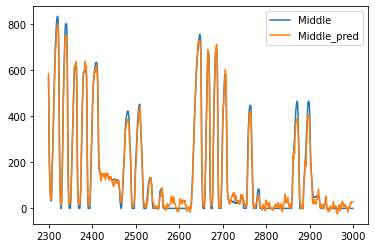

In [74]:
vis[['Middle','Middle_pred']].iloc[2300:3000].plot()

In [73]:
import joblib

model_name = "LSTMBasic2-SEQ-20"

model.save(f"../models/{model_name}.h5")
# Save hand scaler to file.
# Scales the output of the network, the relative position of the hand, min_max
joblib.dump(rel_hand_scaler, f'../models/{model_name}-Hand.gz')

# Scales the input to the network, the emg data. 
joblib.dump(emg_scaler, f'../models/{model_name}-EMG.gz')

['../models/LSTMBasic2-SEQ-20-EMG.gz']

# Simple RNN

In [77]:
from keras.layers import SimpleRNN

In [78]:
df = pd.read_csv("myo_raw_glove2.csv")

y_cols = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']


# Get rid of the [1,2,3,4,5]s from then the labeller was breaking
df = df.iloc[90:]

# Rectify by taking the absolute value
df[x_cols] = abs(df[x_cols])

X = df[x_cols]
y = df[y_cols]

# Scaling
rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(X)

timesteps = 20

def gen_seqs(X, timesteps=2):
    sX = X.astype('float32')
    for col_name in X:
        for t in range(1,timesteps):
            # Add the past col name
            sX[col_name+"_p"+str(t)] = X[col_name].shift(t)
    # Drop NaNs
    sX.dropna(inplace=True)
    return sX

Xs = gen_seqs(X, timesteps)

rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(Xs)

# Ensure all data is a 32bit
nX = nX.astype('float32')
ny = ny.astype('float32')

# Reshape Scaled X
features = X.shape[1]
observations = Xs.shape[0]

nX = nX.reshape(observations, features, timesteps)

# Delete the labels, we no longer have data for
ny = ny[timesteps-1:]

train_X = nX[500:,:]
test_X = nX[:500,:]

train_y = ny[500:,:] # Train on the last 11466
test_y = ny[:500,:] # Test on the last 500

In [79]:
model = Sequential()
# 8 Features and 20 timesteps
model.add(SimpleRNN(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(14))
model.add(Dense(5))

model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 8, 64)             5440      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 14)                462       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                

In [80]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), shuffle=True)

Epoch 1/50
118/118 [==============================] - 8s 27ms/step - loss: 1.0456 - val_loss: 2.3045
Epoch 2/50
118/118 [==============================] - 3s 21ms/step - loss: 0.5484 - val_loss: 2.2755
Epoch 3/50
118/118 [==============================] - 3s 22ms/step - loss: 0.4708 - val_loss: 2.1645
Epoch 4/50
118/118 [==============================] - 2s 21ms/step - loss: 0.4333 - val_loss: 2.2754
Epoch 5/50
118/118 [==============================] - 2s 21ms/step - loss: 0.3943 - val_loss: 1.9981
Epoch 6/50
118/118 [==============================] - 2s 21ms/step - loss: 0.3725 - val_loss: 2.0786
Epoch 7/50
118/118 [==============================] - 2s 21ms/step - loss: 0.3594 - val_loss: 1.8595
Epoch 8/50
118/118 [==============================] - 2s 21ms/step - loss: 0.3421 - val_loss: 2.0042
Epoch 9/50
118/118 [==============================] - 3s 21ms/step - loss: 0.3283 - val_loss: 1.9045
Epoch 10/50
118/118 [==============================] - 2s 21ms/step - loss: 0.3295 - val_lo

16/16 [==============================] - 0s 5ms/step - loss: 1.7516


1.7515877485275269

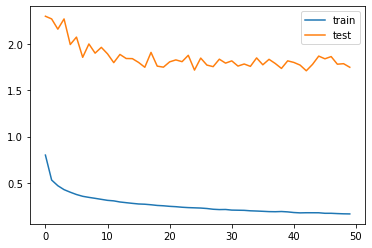

In [81]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

mse = model.evaluate(test_X, test_y)
mse

In [49]:
# Training Set
train_preds = model.predict(train_X) # scaled inputs here

# Scaling back the prediction
train_preds = train_preds * 1024
# Scaling back the goals
train_goal = train_y * 1024

MSE = mean_squared_error(train_goal, train_preds)  # first 2 steps, combined
print("Train MSE: ", MSE)
print("Train RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(train_goal, train_preds)
print("Train MAE: ", MAE)

print()
# Test Set
test_preds = model.predict(test_X) # scaled inputs here

# Scaling back the prediction
test_preds = test_preds * 1024
# Scaling back the goals
test_goal = test_y * 1024

MSE = mean_squared_error(test_goal, test_preds)  # first 2 steps, combined
print("Test MSE: ", MSE)
print("Test RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(test_goal, test_preds)
print("Test MAE: ", MAE)

Train MSE:  58628.78
Train RMSE:  242.1338
Train MAE:  175.85435

Test MSE:  241745.53
Test RMSE:  491.67624
Test MAE:  382.79385


# CuDNNGRU

In [87]:
df = pd.read_csv("myo_raw_glove2.csv")

y_cols = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']


# Get rid of the [1,2,3,4,5]s from then the labeller was breaking
df = df.iloc[90:]

# Rectify by taking the absolute value
df[x_cols] = abs(df[x_cols])

X = df[x_cols]
y = df[y_cols]

# Scaling
rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(X)

timesteps = 20

def gen_seqs(X, timesteps=2):
    sX = X.astype('float32')
    for col_name in X:
        for t in range(1,timesteps):
            # Add the past col name
            sX[col_name+"_p"+str(t)] = X[col_name].shift(t)
    # Drop NaNs
    sX.dropna(inplace=True)
    return sX

Xs = gen_seqs(X, timesteps)

rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(Xs)

# Ensure all data is a 32bit
nX = nX.astype('float32')
ny = ny.astype('float32')

# Reshape Scaled X
features = X.shape[1]
observations = Xs.shape[0]

nX = nX.reshape(observations, features, timesteps)

# Delete the labels, we no longer have data for
ny = ny[timesteps-1:]

train_X = nX[1000:,:]
test_X = nX[:1000,:]

train_y = ny[1000:,:] # Train on the last 11466
test_y = ny[:1000,:] # Test on the last 500

In [89]:
train_X.shape, test_X.shape

((7987, 8, 20), (1000, 8, 20))

In [90]:
from keras.layers import CuDNNGRU, BatchNormalization, Dropout

In [93]:
model = Sequential()
# 8 Features and 20 timesteps
model.add(CuDNNGRU(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(CuDNNGRU(128))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Dense(5))

model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_4 (CuDNNGRU)       (None, 8, 128)            57600     
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 128)            512       
_________________________________________________________________
dropout_10 (Dropout)         (None, 8, 128)            0         
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)              

In [94]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), shuffle=True)

Epoch 1/50
111/111 [==============================] - 3s 13ms/step - loss: 1.4785 - val_loss: 1.8643
Epoch 2/50
111/111 [==============================] - 1s 10ms/step - loss: 0.6301 - val_loss: 1.6736
Epoch 3/50
111/111 [==============================] - 1s 9ms/step - loss: 0.5419 - val_loss: 1.7361
Epoch 4/50
111/111 [==============================] - 1s 9ms/step - loss: 0.4873 - val_loss: 1.7230
Epoch 5/50
111/111 [==============================] - 1s 9ms/step - loss: 0.4558 - val_loss: 1.5339
Epoch 6/50
111/111 [==============================] - 1s 10ms/step - loss: 0.4231 - val_loss: 1.4886
Epoch 7/50
111/111 [==============================] - 1s 10ms/step - loss: 0.4009 - val_loss: 1.4984
Epoch 8/50
111/111 [==============================] - 1s 10ms/step - loss: 0.3828 - val_loss: 1.1511
Epoch 9/50
111/111 [==============================] - 1s 10ms/step - loss: 0.3650 - val_loss: 1.2933
Epoch 10/50
111/111 [==============================] - 1s 10ms/step - loss: 0.3467 - val_loss: